#7. Data Analytics Practicum: NYC Taxi data

이번 시간에는 뉴욕 Manhattan 지역에서 Taxi 운행 기록으로부터 흥미로운 예측 문제를 정의하고, 이를 순차적으로 해결, 발전시켜가는 작업을 해보겠습니다.




##7.1. Loading Data

먼저 https://drive.google.com/drive/folders/14CtOIO0nIrpq-caNO50R-gu3ldjsnr4Z?usp=sharing 에서 데이터 파일을 받아서, access 가능한 Google Drive 공간에 위치시킵니다. 오늘 사용할 데이터는 총 2개의 csv 파일로 구성되어 있습니다:
* trip_data_1.csv
* trip_fare_1.csv

필요한 라이브러리들을 불러들이고, Google Drive와 연결하여 데이터 파일들을 불러올 준비를 합니다.

In [1]:
import numpy as np
import operator

# Mount your Google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


이 시간에는 pandas 라이브러리를 사용하여 데이터를 사용하고자 합니다. Pandas가 제공하는 DataFrame 객체는 데이터분석 작업에 편리한 다양한 기능들을 제공합니다.

먼저 Pandas 라이브러리를 'pd'라는 이름으로 사용할 수 있도록 import 합니다.

In [ ]:
import pandas as pd

다음의 코드에서 등장하는 `read_csv()`는 csv파일을 손쉽게 불러오고, 메모리에 data라는 이름으로 변수화하여, 앞으로 작업에서 편리하게 사용할 수 있게 합니다. 함께 등장하는 N은 편의상 선언되었습니다. 이 튜토리얼에서 8<sup>6</sup>개 만큼의 데이터만 분석에 사용하겠다는 의미로, 앞으로 코드 곳곳에서 등장합니다.




In [ ]:
N = 8e6
data = pd.read_csv('drive/My Drive/datasets/MLPracticum/trip_data_1.csv', nrows=N)

생성된 data 변수는 바로 DataFrame 타입의 객체입니다. DataFrame 형태로 저장된 데이터는 Colab 환경에서 바로 테이블 형태로 출력해볼 수 있습니다. 
다음 코드는 data 변수의 처음 5행 내용을 보여줍니다.

In [ ]:
data[:5]

,medallion,hack_license,vendor_id,rate_code,store_and_fwd_flag,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude
0,89D227B655E5C82AECF13C3F540D4CF4,BA96DE419E711691B9445D6A6307C170,CMT,1,N,2013-01-01 15:11:48,2013-01-01 15:18:10,4,382,1.0,-73.978165,40.757977,-73.989838,40.751171
1,0BD7C8F5BA12B88E0B67BED28BEA73D8,9FD8F69F0804BDB5549F40E9DA1BE472,CMT,1,N,2013-01-06 00:18:35,2013-01-06 00:22:54,1,259,1.5,-74.006683,40.731781,-73.994499,40.750660
2,0BD7C8F5BA12B88E0B67BED28BEA73D8,9FD8F69F0804BDB5549F40E9DA1BE472,CMT,1,N,2013-01-05 18:49:41,2013-01-05 18:54:23,1,282,1.1,-74.004707,40.737770,-74.009834,40.726002
3,DFD2202EE08F7A8DC9A57B02ACB81FE2,51EE87E3205C985EF8431D850C786310,CMT,1,N,2013-01-07 23:54:15,2013-01-07 23:58:20,2,244,0.7,-73.974602,40.759945,-73.984734,40.759388
4,DFD2202EE08F7A8DC9A57B02ACB81FE2,51EE87E3205C985EF8431D850C786310,CMT,1,N,2013-01-07 23:25:03,2013-01-07 23:34:24,1,560,2.1,-73.976250,40.748528,-74.002586,40.747868


또한 DataFrame이 제공하는 `join()` 함수를 이용하면, 두 개의 csv파일로부터 identifier가 같은 instances끼리 합치는 작업도 가능합니다.

**변수 이름 시작 위치에 공백(space)가 있는 이름들이 있습니다. 코드를 옮기는 과정에서 실수하지 않도록 주의하기 바랍니다.**

In [ ]:
fare_data = pd.read_csv('drive/My Drive/datasets/MLPracticum/trip_fare_1.csv', nrows=N)
fare_cols = [u' payment_type', u' fare_amount', u' surcharge', u' mta_tax', u' tip_amount', 
             u' tolls_amount', u' total_amount']
data = data.join(fare_data[fare_cols])
del fare_data
data[:10]
print(data.shape) # print out the size of the data

(49999, 21)


In [ ]:
data.loc[:5, data.columns[:5]]

,medallion,hack_license,vendor_id,rate_code,store_and_fwd_flag
0,89D227B655E5C82AECF13C3F540D4CF4,BA96DE419E711691B9445D6A6307C170,CMT,1,N
1,0BD7C8F5BA12B88E0B67BED28BEA73D8,9FD8F69F0804BDB5549F40E9DA1BE472,CMT,1,N
2,0BD7C8F5BA12B88E0B67BED28BEA73D8,9FD8F69F0804BDB5549F40E9DA1BE472,CMT,1,N
3,DFD2202EE08F7A8DC9A57B02ACB81FE2,51EE87E3205C985EF8431D850C786310,CMT,1,N
4,DFD2202EE08F7A8DC9A57B02ACB81FE2,51EE87E3205C985EF8431D850C786310,CMT,1,N
5,20D9ECB2CA0767CF7A01564DF2844A3E,598CCE5B9C1918568DEE71F43CF26CD2,CMT,1,N


##7.2. Data Visualization and Analysis (with Matplotlib)

이제 데이터를 이해해보는 첫 단계 입니다. `matplotlib`을 사용하여 데이터를 여러 각도에서 시각화하며, 변수들 간의 상관 관계를 파악해봅니다.

#### `trip_time_in_secs` vs. `total_amount` 
먼저 trip_time_in_secs(이동 소요 시간)과 total_amount (이용 총 요금) 간의 관계입니다.

Populating the interactive namespace from numpy and matplotlib


(0.0, 300.0)

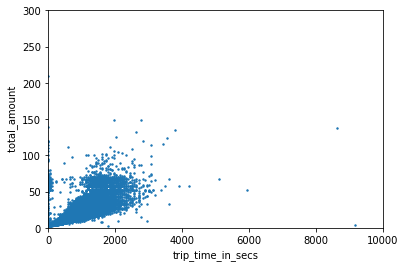

In [ ]:
%pylab inline

data.plot(x="trip_time_in_secs", y=" total_amount", kind="scatter", s=2)
xlim(0,1e4)
ylim(0,300)

위 코드를 실행하면, 다음과 같은 scatterplot을 관찰할 수 있습니다:

![Cannot display the image file](https://raw.githubusercontent.com/charmgil/charmgil.github.io/master/img/nyctaxi_scatterplot.png)

Scatterplot을 통해 두 변수간 상관관계(correlation)을 시각화하여 나타내볼 수 있습니다. 원점으로부터 우상향하는 (위 그림에서 화살표 방향) 직선 형태의 scatter가 선명하게 관찰될 수록, plot이 나타내는 두 변수간 positive하게 강한 상관 관계가 있다고 할 수 있습니다.

반면 plot의 좌측 상단에서 우측 하단방향으로 하강하는 직선 형태가 선명하게 관찰된다면, 두 변수간 negative하게 강한 상관 관계가 있다고 할 수 있습니다.

한편 빨간색 동그라미로 표시된 data instance는 데이터의 주된 영역에서 멀리 떨어져있는 outlier라고 할 수 있습니다 (이동 시간이나 요금이 지나치게 큰 경우). Outlier에 대한 올바른 처리 방법은 문제가 목적하는 바에 따라 여러가지 유효한 답이 있을 수 있습니다. 오늘은 이렇게 특이한 instances를 제거하여 앞으로의 분석이 좀 더 안정적으로 이루어질 수 있게 합니다.

다음 코드를 실행하여 기술된 조건을 만족하는 데이터만 `data`에 남깁니다. 
```
data.trip_time_in_secs < 500, data[' total_amount'] > 30
```


In [ ]:

ind = where(logical_and(data.trip_time_in_secs < 500, data[' total_amount'] > 30))[0]
data = data.drop(ind)
data.shape # print out the size of the data

(49833, 21)

#### Pairplot (`seaborn`)
이제부터 outliers를 제거한 데이터셋으로부터 본격적인 데이터 탐색을 시작합니다. `seaborn` 라이브러리를 이용하여 데이터를 구성하는 모든 변수들 간 scatterplot을 그려봅니다. 단, 약 50000건의 데이터를 모두 사용하면, 시간이 너무 오래 걸리므로, 약 40%의 데이터만 sample하여 plot에 사용합니다.

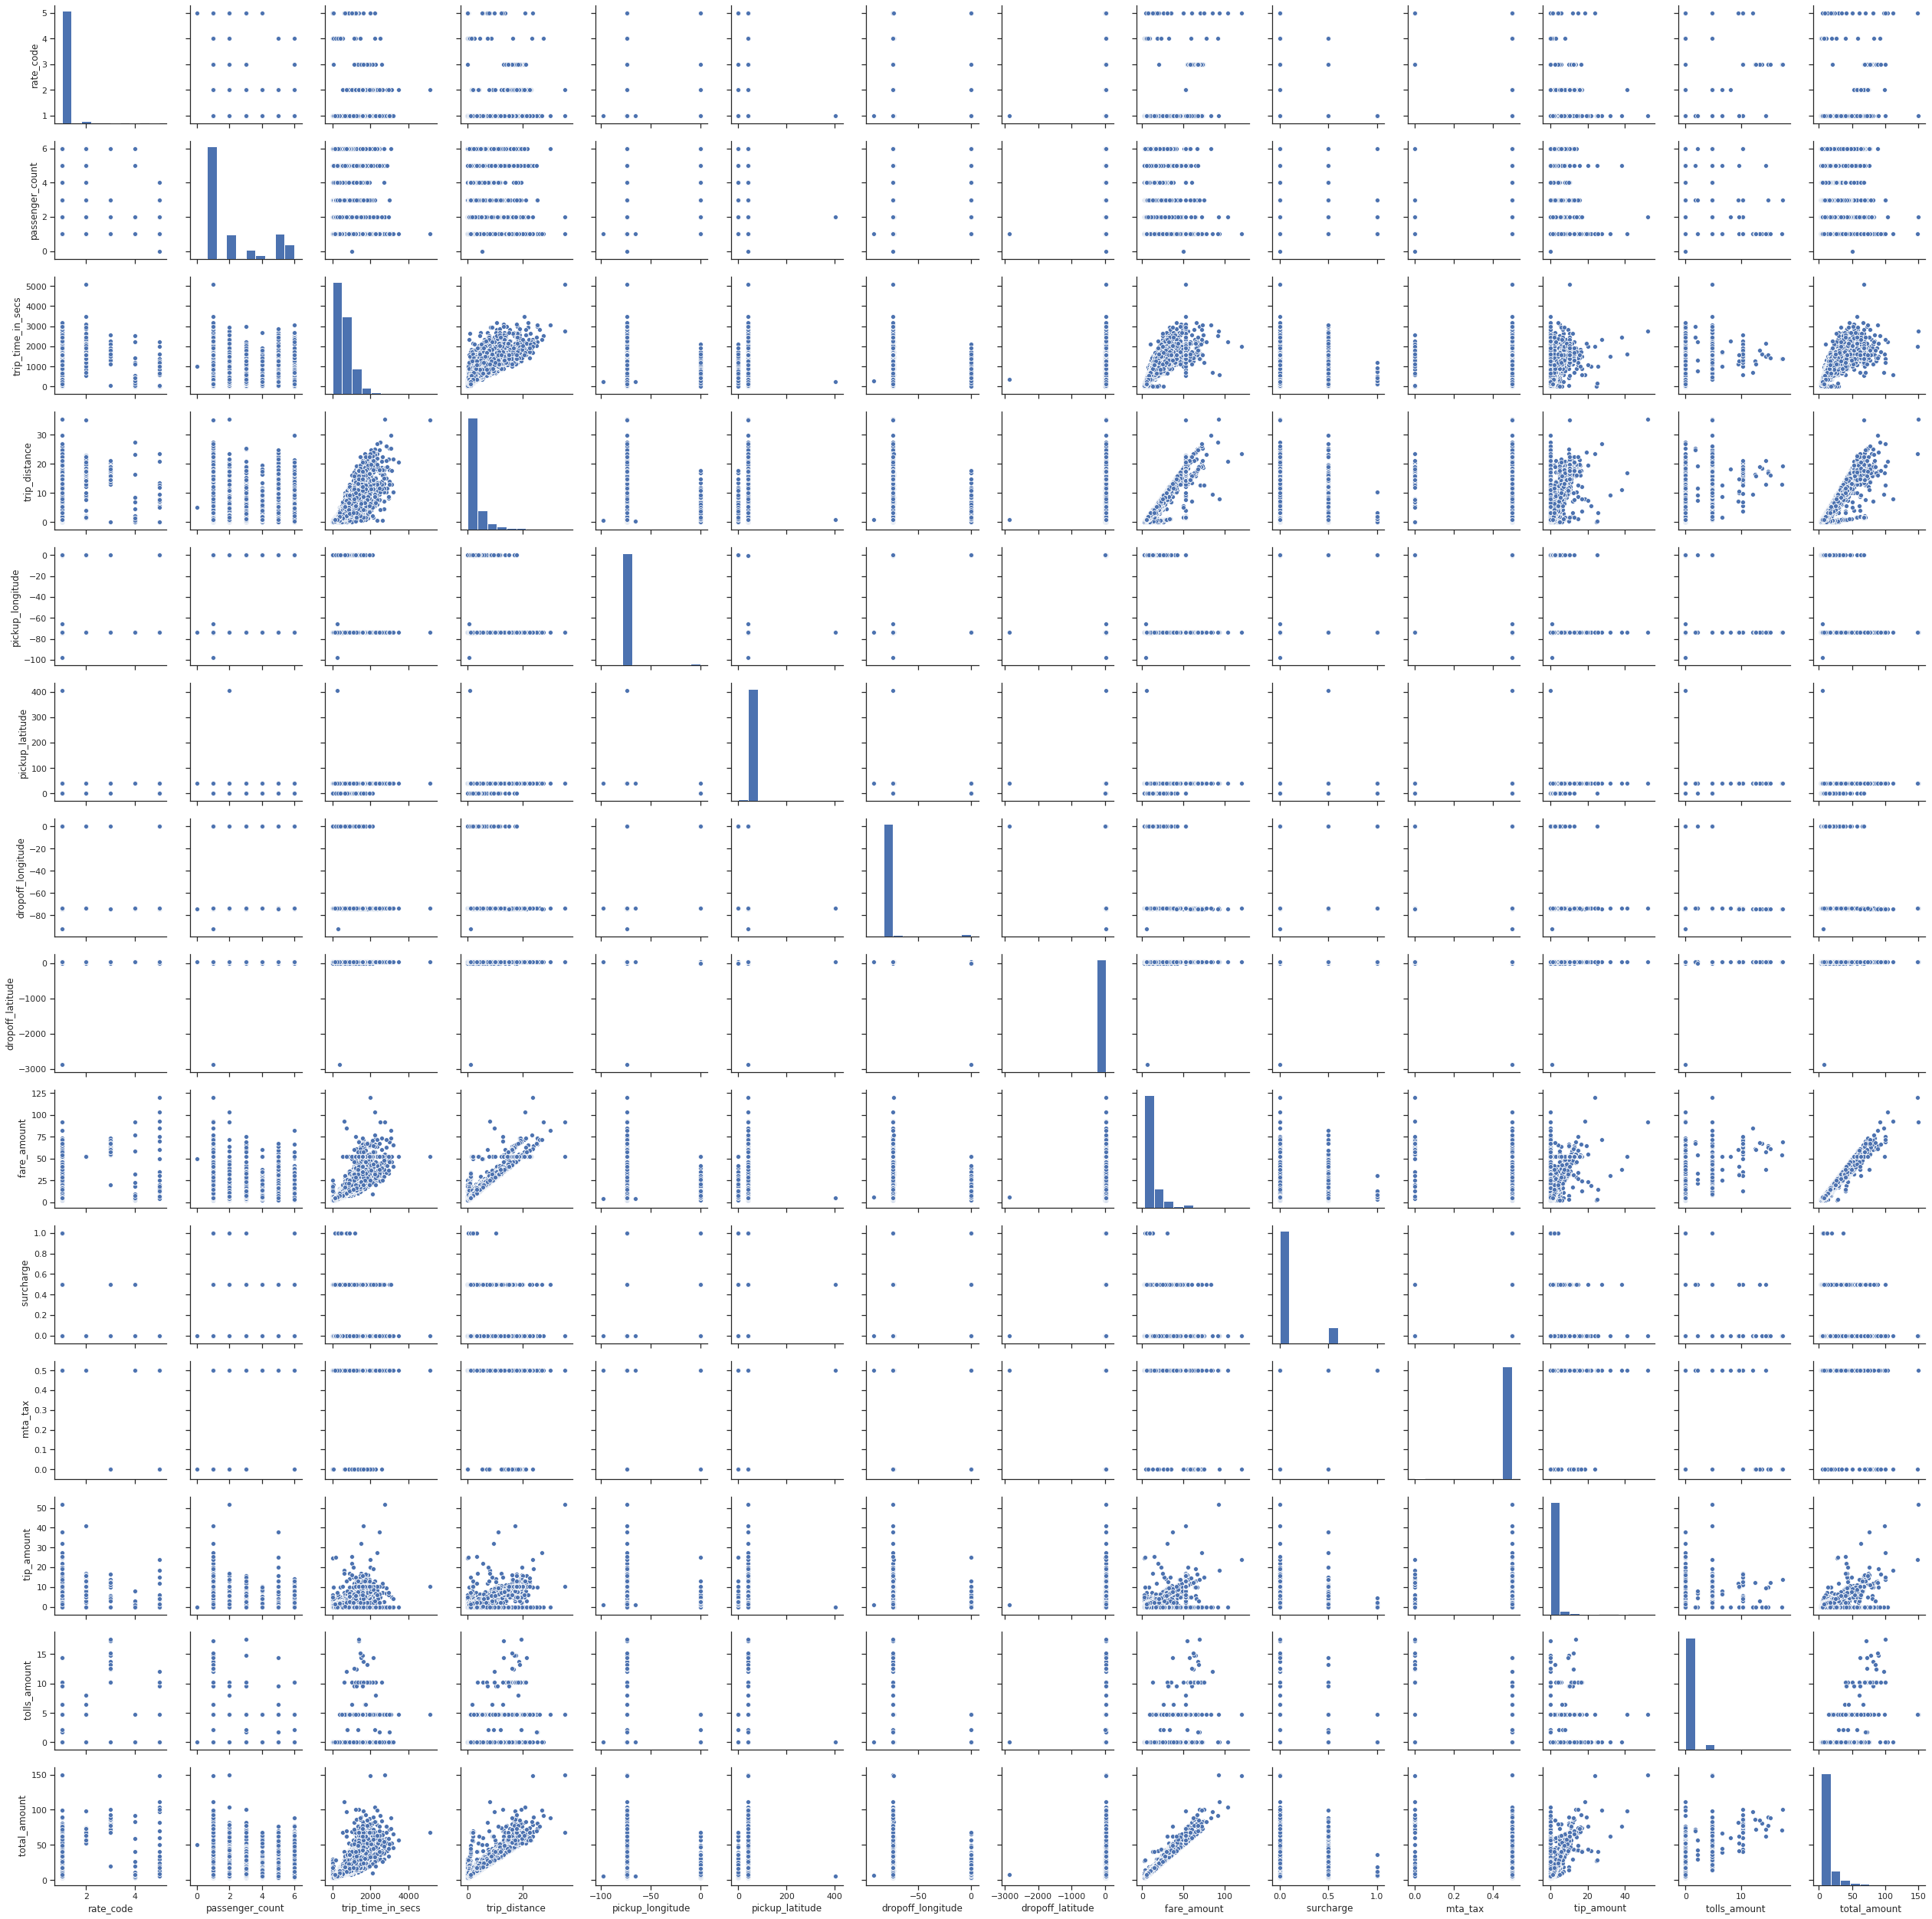

In [ ]:
import seaborn as sns; sns.set(style="ticks", color_codes=True)
g = sns.pairplot(data.sample(20000))

`seaborn`이 제공하는 pairplot 함수를 사용하면 모든 변수글 간 pairwise scatterplot을 한 번에 그려볼 수 있습니다. 대각 위치의 plot들은 해당 변수의 분포를 histogram 형태로 보여줍니다.


다음 질문들에 스스로 답해보며 탐색을 이어갑시다.

Q: `passenger_count`는 탑승한 승객 수를 나타냅니다. `passenger_count` 변수와 가장 높은 상관관계를 보이는 변수는 무엇이 있나요?

Q: `trip_time_in_secs`는 승객이 이동한 시간을 나타냅니다. `trip_time_in_secs` 변수와 가장 높은 상관관계를 보이는 변수는 무엇이 있나요?

Q: `trip_distance`는 승객이 이동한 거리를 나타냅니다. `trip_distance` 변수와 가장 높은 상관관계를 보이는 변수는 무엇이 있나요?

Q: `total_amount`는 승객이 지불한 택시비를 나타냅니다. `total_amount` 변수와 가장 높은 상관관계를 보이는 변수는 무엇이 있나요?

Q: `tip_amount`는 승객이 지불한 택시비 중 tip을 나타냅니다. `tip_amount` 변수와 가장 높은 상관관계를 보이는 변수는 무엇이 있나요?

#### Histogram Analysis

Pairplot의 대각 성분을 따라 확인할 수 있는 히스토그램(histogram)을 살펴보며, 데이터에 대한 탐색을 이어갑니다. 먼저, 하차 지점의 지역적 (in terms of latitudes) 분포를 **위도/경도** 관점에서 각각 살펴봅니다.

*** 개별 변수에 대한 정확한 이해를 위해 개별 변수에 대한 히스토그램을 전체 데이터를 활용하여 다시 그리고 있습니다.** (Recall that we have sampled and used only 40% data for `seaborn`)

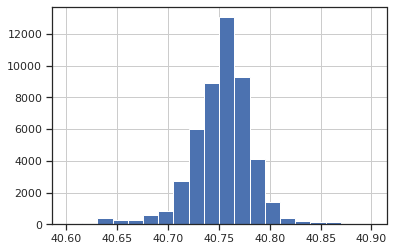

In [ ]:
data[logical_and(data.dropoff_latitude > 40.6,data.dropoff_latitude < 40.9)].dropoff_latitude.hist(bins=20);

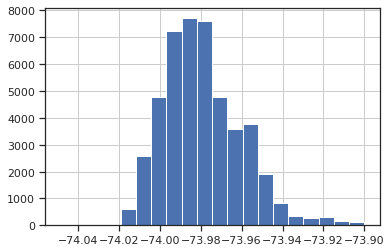

In [ ]:
data[logical_and(data.dropoff_longitude > -74.05,data.dropoff_longitude < -73.9)].dropoff_longitude.hist(bins=20);

데이터에 포함되어 있는 **택시 회사별 분포**도 살펴봅니다. 대부분의 택시가 VTS사 소속임을 알 수 있습니다.

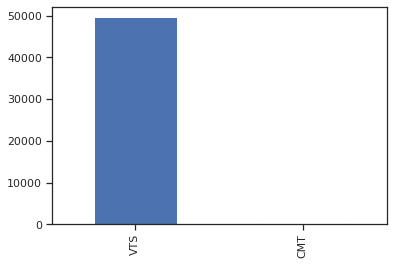

In [ ]:
data.vendor_id.value_counts().plot(kind="bar");

**요금 rate** (지역 및 시간에 따라 1~5 구간의 다른 rate가 적용 됨) 에 따른 데이터의 분포를 살펴 봅니다.

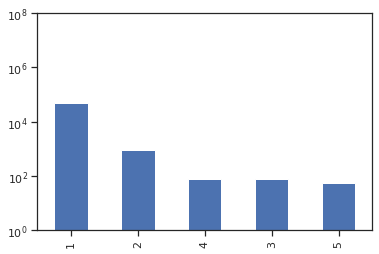

In [ ]:
data.rate_code.value_counts().plot(kind="bar", logy=True, ylim=(1,1e8));

히스토그램을 통해 **동시 탑승 승객의 수**도 살펴봅니다.

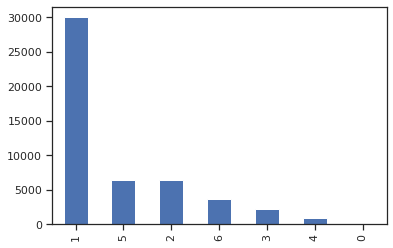

In [ ]:
data.passenger_count.value_counts().plot(kind="bar");

이번엔 **이동에 소요된 시간** 분포를 살펴봅니다.

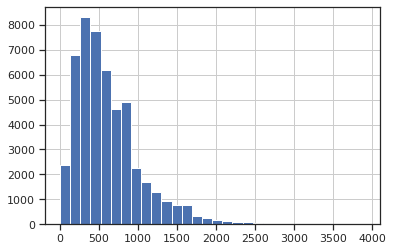

In [ ]:
data.trip_time_in_secs[data.trip_time_in_secs < 4000].hist(bins=30);

마지막으로 **지불 방법**의 분포를 살펴봅니다. CRD = 크레딧카드로 지불, CSH = 현금으로 지불, UNK, DIS, NOD = 기타 비현금성 매체를 이용하여 지불 (교통카드와 유사한 형태)

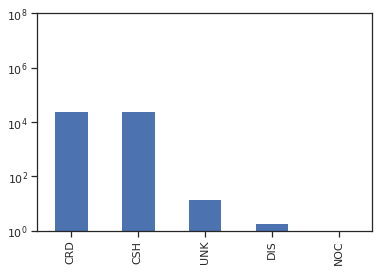

In [ ]:
data[' payment_type'].value_counts().plot(kind="bar", logy=True, ylim=(1,1e8));

#### Scatterplot Analysis

Scatterplot을 통해 **이동 거리**와 **이동 시간** 간의 관계도 살펴봅니다.

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


(0, 40)

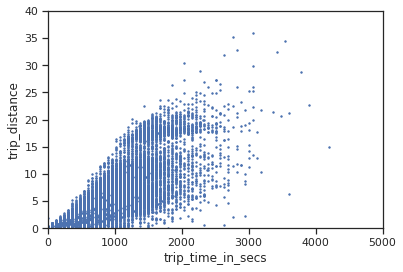

In [ ]:
data.plot(x="trip_time_in_secs", y="trip_distance", kind="scatter", s=2)
xlim(0,5000)
ylim(0,40)

이번엔 탑승 지점 좌표를 화면에 도식해보겠습니다. Manhattan 거리의 형태가 대략 파악이 되나요?

(-74.05, -73.9)

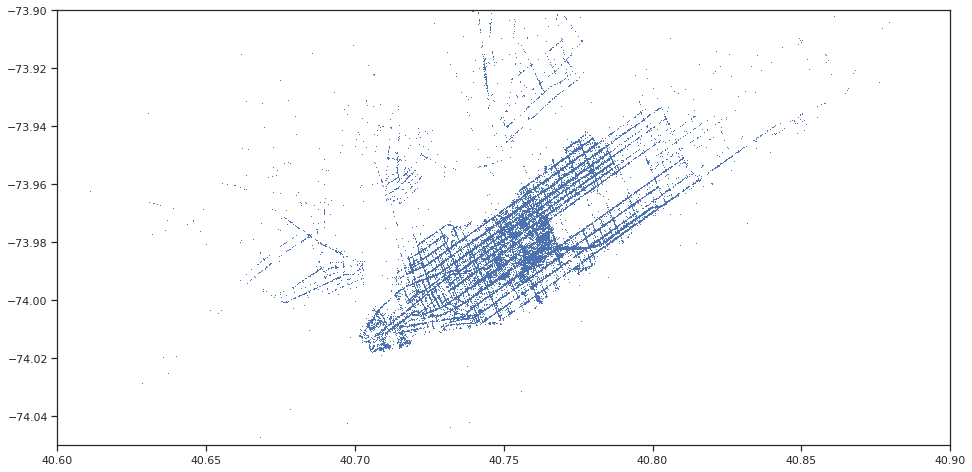

In [ ]:
figure(figsize=(16,8))
plot(data["pickup_latitude"], data["pickup_longitude"], 'b,')
xlim(40.6, 40.9)
ylim(-74.05, -73.9)

## 7.3. Data-driven Problem Solving

위에서 살펴본 데이터셋으로부터 구상해볼 수 있는 흥미롭고 유익한 문제들은 무수히 많을 것입니다. 오늘 실습을 위해 제안하는 문제는 다음과 같습니다.

# 문제: **택시 탑승/운행 기록으로부터 탑승객이 기사님에게 팁을 지불할지 아닐지를 예측해보고자 합니다.**

조금은 정리가 되지 않은 NYC 택시 탑승 기록 데이터로부터 우리가 지난 며칠 간 학습한 ML기법을 활용하는 연습을 해보고자 합니다. 궁극적으로 우리는 탑승객의 tip 지불 여부를 예측하기 위하여 logistic regression 모델을 적용하려고 합니다. 이를 달성하기 위하여 신중하게 데이터 전처리 과정을 거치며 데이터를 logistic regression에 적용 가능하도록 다듬어 가도록 합니다.


승객이 지불한 팁 금액의 분포는 다음과 같습니다. 우리는 이를 binary화 하여, 단순히 팁을 지불하는지 아닌지를 예측해보고자 합니다.

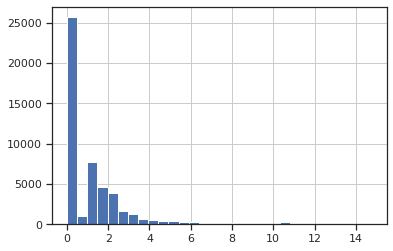

In [ ]:
data[data[' tip_amount'] < 15][' tip_amount'].hist(bins=30);

우리가 가진 데이터의 한 가지 맹점은 tip_amount의 기록이 얼마나 정확한지가 명확하지 않다는 점입니다. 특히 택시비를 현금으로 지불할 경우 잔돈을 모두 tip으로 남기고 하차하는 경우가 많은데, 이 경우 tip_amount를 기록하지 않는 패턴을 확인할 수 있습니다 (오늘 실습에서 이를 확인하는 과정은 생략합니다).

![대체 텍스트](https://raw.githubusercontent.com/charmgil/charmgil.github.io/master/img/tip.png)

반면, 신용카드로 택시비를 지불할 때엔, 탑승객이 직접 tip의 금액을 입력합니다. 이렇게 입력된 내용은 우리가 다루고 있는 데이터에도 반영되어, 신용카드를 사용한 택시비 거래 시, tip 기록이 보다 정확히 기재되어 있는 것을 확인할 수 있습니다 (오늘 실습에서 이를 확인하는 과정은 생략합니다).

![대체 텍스트](https://raw.githubusercontent.com/charmgil/charmgil.github.io/master/img/nyctaxi_paypanel.png)

이러한 관찰을 바탕으로 **신용카드를 사용하여 거래를 한 탑승객의 정보만을 사용하여** 예측 모델 학습을 위한 `data_subset`을 만듭니다. 

In [ ]:
len(data)
data_subset = data[data[' payment_type'] != "CSH"]
data_subset.reset_index(inplace=True, drop=True)
len(data_subset)

25143

##7.3.1. Constructing Predictive Models

예측 작업을 위해 먼저 `tipped`라는 이름의 class label을 만듭니다.

In [ ]:
# Setup target
data_subset['tipped'] = (data_subset[' tip_amount'] > 0).astype("int")
data_subset['tipped'].value_counts()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


1    24179
0      964
Name: tipped, dtype: int64

다음 작업을 통해 예측에 사용될 input attributes (features)를 선택하고, train/test 데이터셋을 구성합니다. 

In [ ]:
feats1 = [u'rate_code', 'passenger_count', u'trip_time_in_secs', u'trip_distance', 
          u'pickup_longitude', u'pickup_latitude', u'dropoff_longitude', u'dropoff_latitude', 
          ' fare_amount', u' surcharge', u' mta_tax', ' tolls_amount']

M = len(data_subset)
rand_idx = arange(M)
random.shuffle(rand_idx)
train_idx = rand_idx[int(M*0.2):]
test_idx = rand_idx[:int(M*0.2)]

In [ ]:
from sklearn.preprocessing import StandardScaler

normalizer = StandardScaler()
normalizer.fit(data_subset.loc[train_idx,feats1])
data_subset_scaled = normalizer.transform(data_subset[feats1])


### Modeling with Logistic Regression

먼저 logistic regression을 사용하여 데이터를 학습하고, tip을 받게 될지, 아닐지 여부를 예측하여 봅니다. 학습 이후에는 accuracy와 auroc라는 평가 방법으로 모델의 성능을 평가해봅니다.

gridsearch.best_params_ = {'C': 0.0001, 'penalty': 'l2'}
test_acc = 0.9620127287191726
test_auc = 0.5734277769419192


Text(0, 0.5, 'True positive rate')

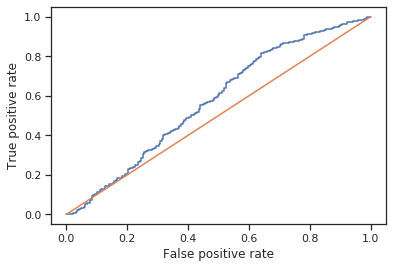

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)
warnings.simplefilter(action='ignore', category=ConvergenceWarning)

from sklearn.metrics import (accuracy_score, precision_score, 
                             recall_score, f1_score, log_loss, 
                             roc_curve, roc_auc_score)

logreg = LogisticRegression()
parameters = {'penalty': ['l2'],
              'C': [10e-5, 10e-3, 10e-2, 10e-1, 10e0, 10e1, 10e2, 10e3, 10e5]}
gridsearch = GridSearchCV(logreg, parameters, scoring='accuracy', cv=5)
gridsearch.fit(data_subset.loc[train_idx,feats1], data_subset['tipped'].loc[train_idx])
print(f'gridsearch.best_params_ = {gridsearch.best_params_}')

# Step 3: Get model with best hyperparameters
best_logreg = gridsearch.best_estimator_

# Step 4: Get best model performance from testing set
# binary prediction (0/1)
y_pred = best_logreg.predict(data_subset.ix[test_idx,feats1])
# probability estimation [0, 1]
y_prob = best_logreg.predict_proba(data_subset.ix[test_idx,feats1])
test_acc = accuracy_score(data_subset['tipped'].loc[test_idx], y_pred)
print(f'test_acc = {test_acc}')


fpr, tpr, thr = roc_curve(data_subset['tipped'].loc[test_idx], y_prob[:,1])
test_auc = roc_auc_score(data_subset['tipped'].loc[test_idx], y_prob[:,1])
print(f'test_auc = {test_auc}')

plot(fpr,tpr)
plot(fpr,fpr)
xlabel("False positive rate")
ylabel("True positive rate")


### Modeling with Random Forest

이번엔 random forest를 사용하여 같은 작업을 반복해 봅니다. 앞서 logistic regression의 성능과 비교를 해볼까요?

gridsearch.best_params_ = {'criterion': 'entropy', 'n_estimators': 150}
test_acc = 0.9608194112967383
test_auc = 0.5981997408717921


Text(0, 0.5, 'True positive rate')

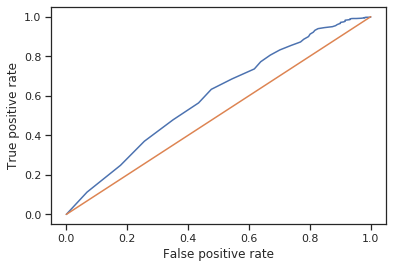

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
parameters = {'n_estimators': [150],
              'criterion': ['gini', 'entropy']}
gridsearch = GridSearchCV(rf, parameters, scoring='accuracy', cv=5)
gridsearch.fit(data_subset.loc[train_idx,feats1], data_subset['tipped'].loc[train_idx])
print(f'gridsearch.best_params_ = {gridsearch.best_params_}')

# Step 3: Get model with best hyperparameters
best_rf = gridsearch.best_estimator_

# Step 4: Get best model performance from testing set
# binary prediction (0/1)
y_pred = best_rf.predict(data_subset.loc[test_idx,feats1])
# probability estimation [0, 1]
y_prob = best_rf.predict_proba(data_subset.loc[test_idx,feats1])
test_acc = accuracy_score(data_subset['tipped'].loc[test_idx], y_pred)
print(f'test_acc = {test_acc}')

fpr, tpr, thr = roc_curve(data_subset['tipped'].loc[test_idx], y_prob[:,1])
test_auc = roc_auc_score(data_subset['tipped'].loc[test_idx], y_prob[:,1])
print(f'test_auc = {test_auc}')

plot(fpr,tpr)
plot(fpr,fpr)
xlabel("False positive rate")
ylabel("True positive rate")


### Model Analysis

Random Forest가 제공하는 멤버 `feature_importances_`를 사용하여, input features를 중요도 순으로 나열해 봅니다.

In [ ]:
fi = zip(feats1, best_rf.feature_importances_)
# fi.sort(key=lambda x: -x[1])
df=pd.DataFrame(fi, columns=["Feature","Importance"])
df.sort_values(["Importance"], ascending=False)

,Feature,Importance
5,pickup_latitude,0.157779
6,dropoff_longitude,0.156491
7,dropoff_latitude,0.153933
4,pickup_longitude,0.152321
3,trip_distance,0.148188
8,fare_amount,0.088052
2,trip_time_in_secs,0.081908
1,passenger_count,0.038382
9,surcharge,0.012206
11,tolls_amount,0.005219


지금까지 택시 운행 기록의 위치, 시간, 이동 거리 및 요금 등의 정보를 바탕으로, 탑승객이 기사님께 팁을 줄지, 아니면 주지 않을지 여부를 예측해 보았습니다.

##7.3.2. Improving the Model Performance by Adding Features

### Improving Input Features #1

그런데 말입니다, **'이동 속도'**라는 기존에 고려되지 않던 정보를 이용하면, 탑승객의 팁 지불 여부를 더 정확하게 예측 할 수 있을 것이라는 인사이트가 떠올랐습니다. 속도는 이동거리/이동시간을 계산하여 구할 수 있습니다. 해당 정보를 모델에 어떻게 추가할 수 있을까요?

In [ ]:
data_subset.loc[data_subset['trip_time_in_secs'] < 1e-3,'trip_time_in_secs'] = -1
data_subset['speed'] = data_subset['trip_distance'] / data_subset['trip_time_in_secs']

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
feats2 = feats1 + ['speed']
feats2.remove('trip_time_in_secs')

normalizer = StandardScaler()
normalizer.fit(data_subset.loc[train_idx,feats2])
data_subset_scaled = normalizer.transform(data_subset[feats2])

gridsearch.best_params_ = {'criterion': 'gini', 'n_estimators': 150}
test_acc = 0.961217183770883
test_auc = 0.6152471080794097


Text(0, 0.5, 'True positive rate')

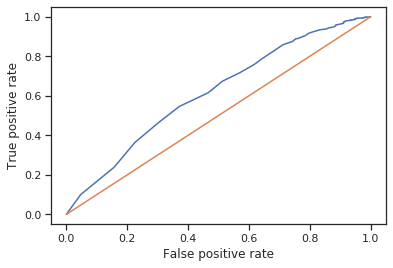

In [ ]:
rf = RandomForestClassifier()
parameters = {'n_estimators': [150],
              'criterion': ['gini', 'entropy']}
gridsearch = GridSearchCV(rf, parameters, scoring='accuracy', cv=5)
gridsearch.fit(data_subset.loc[train_idx,feats2], data_subset['tipped'].loc[train_idx])
print(f'gridsearch.best_params_ = {gridsearch.best_params_}')

# Step 3: Get model with best hyperparameters
best_rf = gridsearch.best_estimator_

# Step 4: Get best model performance from testing set
# binary prediction (0/1)
y_pred = best_rf.predict(data_subset.ix[test_idx,feats2])
# probability estimation [0, 1]
y_prob = best_rf.predict_proba(data_subset.ix[test_idx,feats2])
test_acc = accuracy_score(data_subset['tipped'].loc[test_idx], y_pred)
print(f'test_acc = {test_acc}')

fpr, tpr, thr = roc_curve(data_subset['tipped'].ix[test_idx], y_prob[:,1])
test_auc = roc_auc_score(data_subset['tipped'].ix[test_idx], y_prob[:,1])
print(f'test_auc = {test_auc}')

plot(fpr,tpr)
plot(fpr,fpr)
xlabel("False positive rate")
ylabel("True positive rate")


Q: 앞의 RF수행 결과와 비교하여 성능 향상이 있나요?

새로 추가한 speed 항목이 예측에 얼마나 영향을 주는지도 찾아볼까요?

In [ ]:
fi = zip(feats2, best_rf.feature_importances_)
# fi.sort(key=lambda x: -x[1])
df=pd.DataFrame(fi, columns=["Feature","Importance"])
df.sort_values(["Importance"], ascending=False)

,Feature,Importance
4,pickup_latitude,0.151379
5,dropoff_longitude,0.148805
6,dropoff_latitude,0.147883
3,pickup_longitude,0.144555
11,speed,0.138617
2,trip_distance,0.130351
7,fare_amount,0.084031
1,passenger_count,0.034538
8,surcharge,0.008752
10,tolls_amount,0.005503


### Improving Input Features #2

마지막으로 지금까지 사용하지 않은 시간 정보를 이용하여 탑승객의 팁 지불 여부를 예측해보겠습니다. 데이터셋에는 탑승 및 하차 시간이 timestamp의 형태로 기입되어 있습니다. 하지만 우리의 ML 모델들은 timestamp 형태의 데이터를 쉽게 처리하지 못합니다.

모델 학습을 위해 timestamp를 좀 더 의미있는 형태로 변형시켜 보겠습니다.

In [ ]:
feats3 = feats2

# Datetime features (hour of day, day of week, week of year)
pickup = pd.to_datetime(data['pickup_datetime'])
dropoff = pd.to_datetime(data['dropoff_datetime'])
data['pickup_hour'] = pickup.apply(lambda e: e.hour)
data['pickup_day'] = pickup.apply(lambda e: e.dayofweek)
#data['pickup_week'] = pickup.apply(lambda e: e.week)
data['dropoff_hour'] = dropoff.apply(lambda e: e.hour)
data['dropoff_day'] = dropoff.apply(lambda e: e.dayofweek)
#data['dropoff_week'] = dropoff.apply(lambda e: e.week)

feats3 += ['pickup_hour', 'pickup_day', 'dropoff_hour', 'dropoff_day']

변형한 시간 정보를 포함하여 모델을 다시 학습해봅니다.

gridsearch.best_params_ = {'criterion': 'entropy', 'n_estimators': 150}
test_acc = 0.9608194112967383
test_auc = 0.5970632136443882


,Feature,Importance
6,dropoff_longitude,0.157726
7,dropoff_latitude,0.155140
5,pickup_latitude,0.155074
4,pickup_longitude,0.153083
3,trip_distance,0.144786
8,fare_amount,0.090418
2,trip_time_in_secs,0.083481
1,passenger_count,0.038150
9,surcharge,0.011972
11,tolls_amount,0.004941


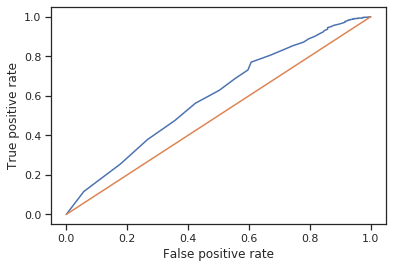

In [ ]:
rf = RandomForestClassifier()
parameters = {'n_estimators': [150],
              'criterion': ['gini', 'entropy']}
gridsearch = GridSearchCV(rf, parameters, scoring='accuracy', cv=5)
gridsearch.fit(data_subset.loc[train_idx,feats1], data_subset['tipped'].loc[train_idx])
print(f'gridsearch.best_params_ = {gridsearch.best_params_}')

# Step 3: Get model with best hyperparameters
best_rf = gridsearch.best_estimator_

# Step 4: Get best model performance from testing set
# binary prediction (0/1)
y_pred = best_rf.predict(data_subset.ix[test_idx,feats1])
# probability estimation [0, 1]
y_prob = best_rf.predict_proba(data_subset.ix[test_idx,feats1])
test_acc = accuracy_score(data_subset['tipped'].loc[test_idx], y_pred)
print(f'test_acc = {test_acc}')

fpr, tpr, thr = roc_curve(data_subset['tipped'].ix[test_idx], y_prob[:,1])
test_auc = roc_auc_score(data_subset['tipped'].ix[test_idx], y_prob[:,1])
print(f'test_auc = {test_auc}')

plot(fpr,tpr)
plot(fpr,fpr)
xlabel("False positive rate")
ylabel("True positive rate")

fi = zip(feats1, best_rf.feature_importances_)
# fi.sort(key=lambda x: -x[1])
df=pd.DataFrame(fi, columns=["Feature","Importance"])
df.sort_values(["Importance"], ascending=False)

Q: 이번엔 어떤가요? 또 다시 성능 향상이 있나요?

## Wrap-up

지금까지 NYC Taxi Data를 간단히 분석해보고, 이로부터 탑승객의 팁 지불 여부를 예측해보는 작업을 해보았습니다.

마지막으로 탑승객의 승하자 지점과, 팁 지불 여부를 바탕으로 재구성한 뉴욕의 지도입니다. 지도에 나타나는 파란색 점은 팁이 지불된 trip, 빨간색 점은 팁이 지불되지 않은 trip을 의미합니다.


(-74.03, -73.93)

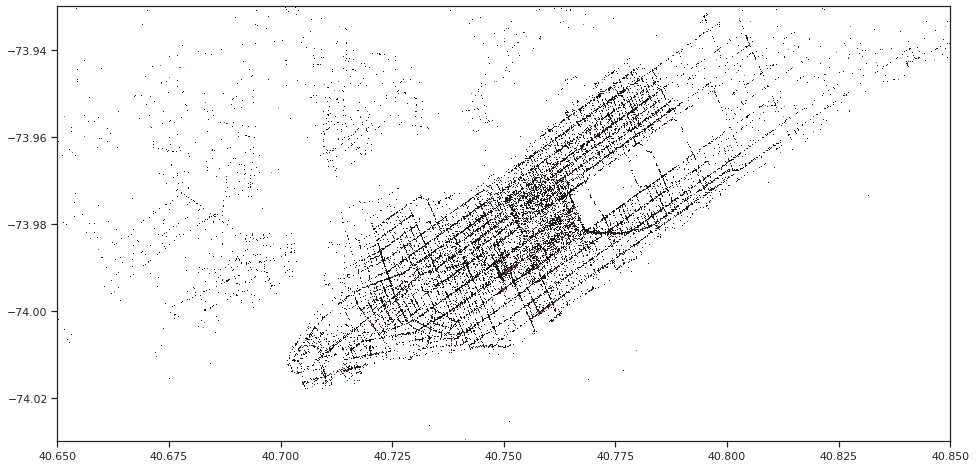

In [ ]:
figure(figsize=(16,8))
plot(data_subset[data_subset['tipped'] == True]["dropoff_latitude"], 
     data_subset[data_subset['tipped'] == True]["dropoff_longitude"], 'k,')
plot(data_subset[data_subset['tipped'] == False]["dropoff_latitude"], 
     data_subset[data_subset['tipped'] == False]["dropoff_longitude"], 'r,')
xlim(40.65, 40.85)
ylim(-74.03, -73.93)

In [2]:
!apt-get install texlive texlive-xetex texlive-latex-extra pandoc
!pip install pypandoc

Reading package lists... Done
Building dependency tree       
Reading state information... Done
pandoc is already the newest version (1.19.2.4~dfsg-1build4).
pandoc set to manually installed.
The following additional packages will be installed:
  fonts-droid-fallback fonts-lato fonts-lmodern fonts-noto-mono fonts-texgyre
  javascript-common libcupsfilters1 libcupsimage2 libgs9 libgs9-common
  libijs-0.35 libjbig2dec0 libjs-jquery libkpathsea6 libpotrace0 libptexenc1
  libruby2.5 libsynctex1 libtexlua52 libtexluajit2 libzzip-0-13 lmodern
  poppler-data preview-latex-style rake ruby ruby-did-you-mean ruby-minitest
  ruby-net-telnet ruby-power-assert ruby-test-unit ruby2.5
  rubygems-integration t1utils tex-common tex-gyre texlive-base
  texlive-binaries texlive-fonts-recommended texlive-latex-base
  texlive-latex-recommended texlive-pictures texlive-plain-generic tipa
Suggested packages:
  fonts-noto apache2 | lighttpd | httpd poppler-utils ghostscript
  fonts-japanese-mincho | fonts-ipa

In [5]:
!jupyter nbconvert --to PDF '/content/drive/MyDrive/0_한동생활/2020-2.5 겨울방학/0_ML_Camp_TA/0_Translation_KOR2ENG./KOR/day1-1.ipynb' 'UTF-8'
!jupyter nbconvert --to PDF '/content/drive/MyDrive/0_한동생활/2020-2.5 겨울방학/0_ML_Camp_TA/0_Translation_KOR2ENG./KOR/day1-2.ipynb'
!jupyter nbconvert --to PDF '/content/drive/MyDrive/0_한동생활/2020-2.5 겨울방학/0_ML_Camp_TA/0_Translation_KOR2ENG./KOR/day2-1.ipynb'
!jupyter nbconvert --to PDF '/content/drive/MyDrive/0_한동생활/2020-2.5 겨울방학/0_ML_Camp_TA/0_Translation_KOR2ENG./KOR/day2-2.ipynb'
!jupyter nbconvert --to PDF '/content/drive/MyDrive/0_한동생활/2020-2.5 겨울방학/0_ML_Camp_TA/0_Translation_KOR2ENG./KOR/day3-1.ipynb'
!jupyter nbconvert --to PDF '/content/drive/MyDrive/0_한동생활/2020-2.5 겨울방학/0_ML_Camp_TA/0_Translation_KOR2ENG./KOR/day3-2.ipynb'
!jupyter nbconvert --to PDF '/content/drive/MyDrive/0_한동생활/2020-2.5 겨울방학/0_ML_Camp_TA/0_Translation_KOR2ENG./KOR/day4-1.ipynb'
!jupyter nbconvert --to PDF '/content/drive/MyDrive/0_한동생활/2020-2.5 겨울방학/0_ML_Camp_TA/0_Translation_KOR2ENG./KOR/day4-2.ipynb'
!jupyter nbconvert --to PDF '/content/drive/MyDrive/0_한동생활/2020-2.5 겨울방학/0_ML_Camp_TA/0_Translation_KOR2ENG./KOR/day5-1.ipynb'


[NbConvertApp] WARNING | pattern u'UTF-8' matched no files
[NbConvertApp] Converting notebook /content/drive/MyDrive/0_한동생활/2020-2.5 겨울방학/0_ML_Camp_TA/0_Translation_KOR2ENG./KOR/day1-1.ipynb to PDF
[NbConvertApp] Writing 50690 bytes to ./notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: [u'xelatex', u'./notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: [u'bibtex', u'./notebook']
[NbConvertApp] WARNING | bibtex had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 48676 bytes to /content/drive/MyDrive/0_한동생활/2020-2.5 겨울방학/0_ML_Camp_TA/0_Translation_KOR2ENG./KOR/day1-1.pdf
[NbConvertApp] Converting notebook /content/drive/MyDrive/0_한동생활/2020-2.5 겨울방학/0_ML_Camp_TA/0_Translation_KOR2ENG./KOR/day1-2.ipynb to PDF
[NbConvertApp] Support files will be in day1-2_files/
[NbConvertApp] Making directory ./day1-2_files
[NbConvertApp] Making directory ./day1-2_files
[NbConvertApp] Writing 1